# JPMorgan Chase & Co. Quantitative Research Job Simulation
## Task 3

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

## Data Exploration

In [172]:
# Configure plot style
plt.style.use('dark_background')

# Load the data
df = pd.read_csv(r'C:\Users\Babanz\VS\quant\JPMC-Forage\Data\Loan_Data.csv')

# Select what data to view
data_view = 2

match data_view:
    case 1:
        df.info()
    case 2:
        print(df.tail())
    case 3:
        print(df.describe())

      customer_id  credit_lines_outstanding  loan_amt_outstanding  \
9995      3972488                         0           3033.647103   
9996      6184073                         1           4146.239304   
9997      6694516                         2           3088.223727   
9998      3942961                         0           3288.901666   
9999      5533570                         1           1917.652480   

      total_debt_outstanding       income  years_employed  fico_score  default  
9995             2553.733144  42691.62787               5         697        0  
9996             5458.163525  79969.50521               8         615        0  
9997             4813.090925  38192.67591               5         596        0  
9998             1043.099660  50929.37206               2         647        0  
9999             3050.248203  30611.62821               6         757        0  


From the data exploration, we conclude that we have 10,000 entries with no missing data. We have 8 columns of data. Let us try to establish useful features.

In [173]:
# Create a dataframe for the features
df_features = df.copy()

# Create a dataframe for the labels
df_labels = df.copy()

# We need just the defaults for our labels
df_labels = df_labels['default']

# Drop the customer ID and the default as a feature
df_features = df_features.drop(columns=['customer_id', 'default'])

# Create useful features
df_features['loan_to_income'] = df_features['loan_amt_outstanding'].values / df_features['income'].values   # Loan to income ratio
df_features['debt_to_income'] = df_features['total_debt_outstanding'].values / df_features['income'].values # Debt to income ratio

### Correlation Heatmap

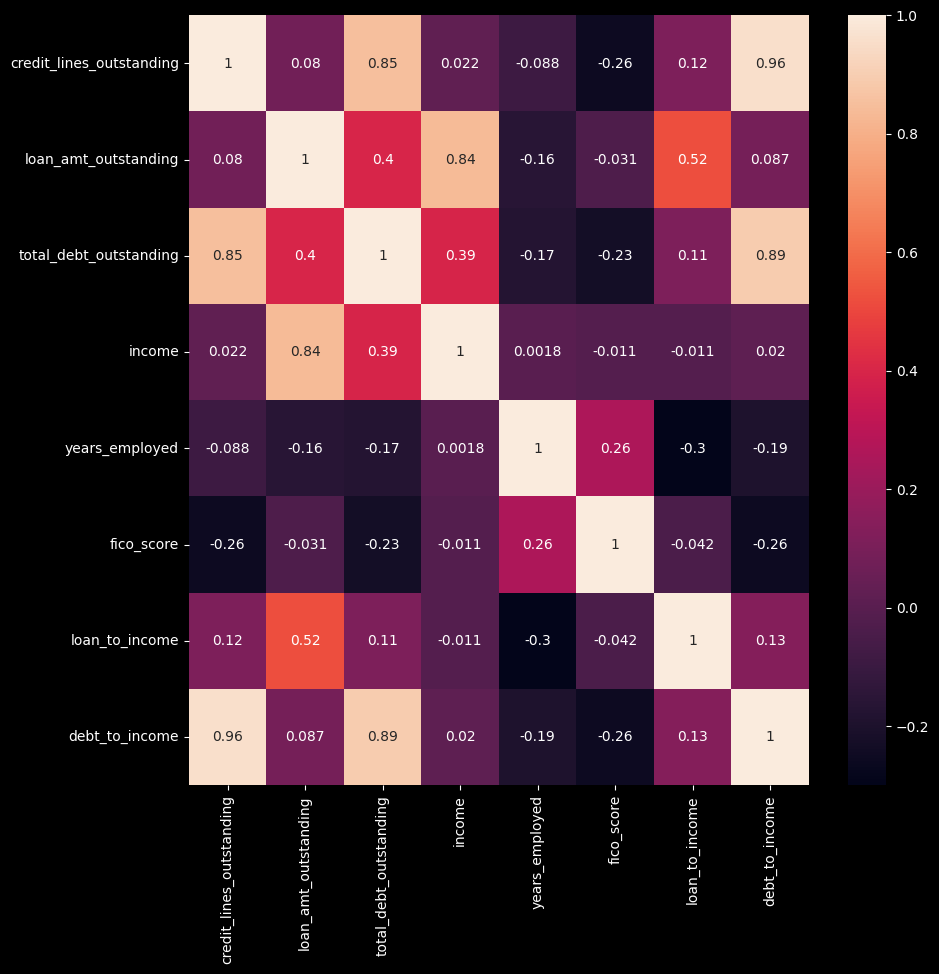

In [174]:
features_correlation = df_features.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(features_correlation, annot=True)
plt.show()

### Scatter Matrix

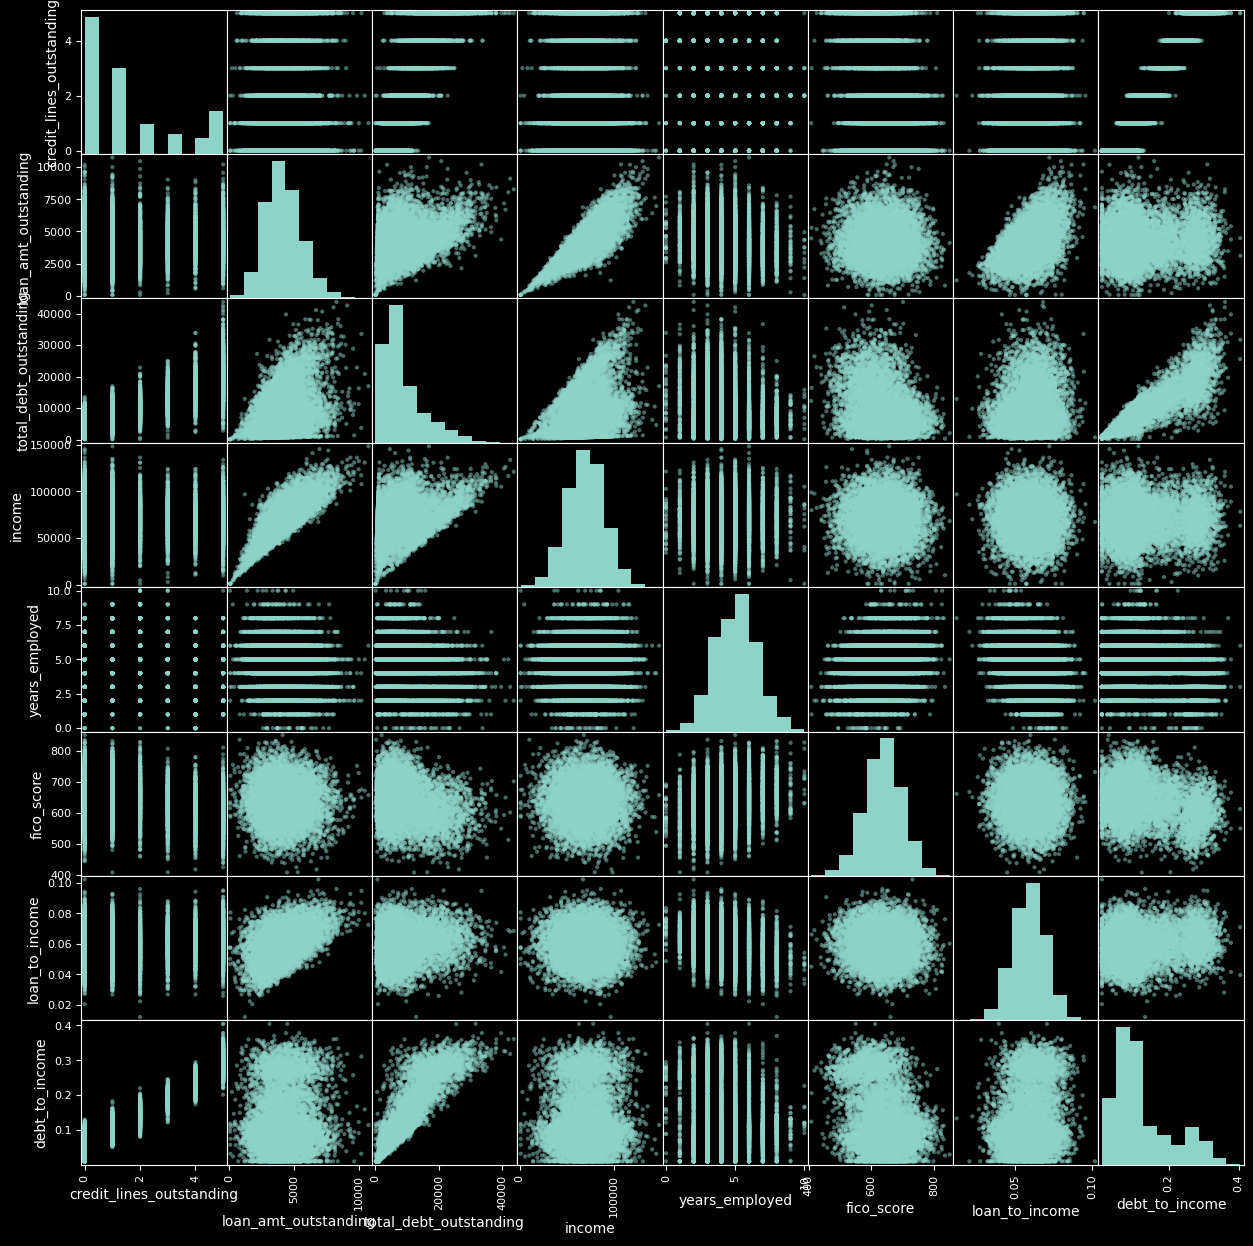

In [175]:
scatter_matrix(df_features, figsize=(15, 15))
plt.show()

## Data Inference

In [176]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_features)
y = df_labels

# Split dataset into training and testing for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM

In [177]:
# SVM hyperparameters for grid-search
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'class_weight': [None, 'balanced']
}

# SVM model
svm = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=svm_params,
    scoring='roc_auc',
    cv=10,
    verbose=2,
    n_jobs=-1
)

# Fit the SVM
svm.fit(X_train, y_train)

# Print best hyperparameters and score
print('Best Hyperparameters:', svm.best_params_)
print('Best ROC AUC:', svm.best_score_)

# Evaluate test set performance
y_pred = svm.best_estimator_.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred, digits=4))

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best ROC AUC: 0.9999979487179488
Test Accuracy: 0.999
Classification Report:
               precision    recall  f1-score   support

           0     0.9994    0.9994    0.9994      1652
           1     0.9971    0.9971    0.9971       348

    accuracy                         0.9990      2000
   macro avg     0.9983    0.9983    0.9983      2000
weighted avg     0.9990    0.9990    0.9990      2000



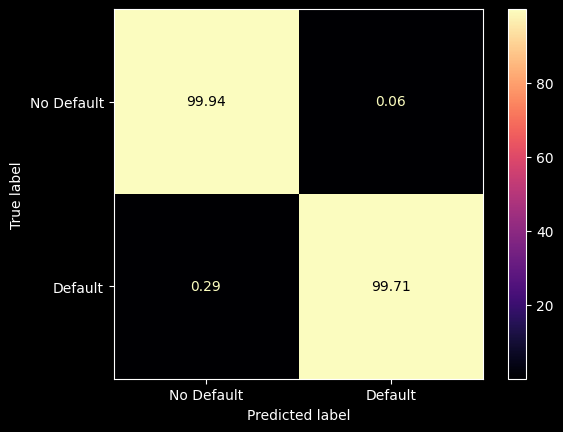

In [178]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot CM
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['No Default', 'Default'])
disp.plot(cmap='magma', values_format='.2f')
plt.show()

## Expected loss from defaulting a loan
- We are given a recovery rate, denoted by $r$, of 10% and we need to find the expected loss denoted by $\text{EL}$.
- We can compute the loss in USD by multiplying by the loan amount denoted by $A$.
$$
    \text{EL} \, (\$) = \mathbb{P}[\text{Default} | \text{Borrower Features}] \times (1 - r) \times A
$$
- Where $\mathbb{P}[\text{Default} | \text{Borrower Features}]$ is obtained from our machine learning classifier.

In [179]:
def expected_loss(model, features, A, r=0.1) -> float:
    """
    Calculate the expected loss of a loan.

    Args:
        model: Trained classifier with predict_proba method.
        features: Borrower features (1 row, preprocessed if necessary).
        A: Loan amount in dollars.
        r: Recovery rate (default = 10%).

    Returns:
        Expected loss in USD.
    """
    # Perform prediction to find probability of default
    prob_default = model.predict_proba(features)[:, 1]

    # Ensure loss and probability are floats
    loss = float(prob_default[0] * (1 - r) * A)
    prob = float(prob_default[0])

    # Print information regarding defaulting and expected loss
    print(f'Client has {prob * 100:.2f}% probability of defaulting.')
    print(f'Expected loss from defaulting is ${loss:.2f}.')

    return (loss, prob)

# Create a test client
client =  pd.DataFrame([{
    'credit_lines_outstanding': 2,
    'loan_amt_outstanding': 10000.0,
    'total_debt_outstanding': 25000.0,
    'income': 90000.00,
    'years_employed': 3,
    'fico_score': 650
}])

client['loan_to_income'] = client['loan_amt_outstanding'] / client['income']
client['debt_to_income'] = client['total_debt_outstanding'] / client['income']

# How much is borrowed
loan_amount = 50000.00

# Ensure features are scaled
client_scaled = scaler.transform(client)

# Compute the loss on default
loss, prob_default = expected_loss(svm, client_scaled, loan_amount)

Client has 75.03% probability of defaulting.
Expected loss from defaulting is $33765.45.
